# This notebook explores how to leverage a pre-trained DeepLabV3 backbone to solve the Seismic task


##  1. Initial setup

In [2]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Flags to control wether or not to run unity tests and to show predictions.
run_unity_tests = True
show_predictions = True

In [9]:
import os

# DeepLabV3 backbone pretrained weights filename
pretrained_weights_filename = f'backbone_parameters-BT-pretext-with-10-epochs.pth'

# Check if file exists
if not os.path.exists(pretrained_weights_filename):
    raise Exception(f"Could not find file {pretrained_weights_filename}. "+
                    "Please set the pretrained_weights_filename variable with a valid filename.")


# 2. Build the downstream model



Build the downstream model

In [10]:
# Build the downstream model
import models.deeplabv3 as dlv3

# Build and load the backbone weights
backbone = dlv3.DeepLabV3Backbone()
backbone.load_state_dict(torch.load(pretrained_weights_filename))

# Build the downstream model
downstream_model = dlv3.DeepLabV3Model(backbone = backbone, num_classes=6)
downstream_model.to(device=device)

if True:
    # Test the model
    random_input = torch.rand(2,3,255,701).to(device=device)
    output = downstream_model(random_input)
    print("output_shape = ", output.shape)

output_shape =  torch.Size([2, 6, 255, 701])


# 3. Setup the dataloaders



In [11]:
from data_modules.seismic import F3SeismicDataModule

# Instantiating the HarDataModule with root dir at data/example
data_module = F3SeismicDataModule("data/", batch_size=8)
train_dl = data_module.train_dataloader(drop_last=True)
val_dl   = data_module.val_dataloader()
test_dl  = data_module.test_dataloader()

# 4. Evaluate the untrained model



In [14]:
from torchmetrics import JaccardIndex

def evaluate_model(model, dataset_dl):
    # Inicialize JaccardIndex metric
    jaccard = JaccardIndex(task="multiclass", num_classes=6)

    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # For each batch, compute the predictions and compare with the labels.
    for X, y in dataset_dl:
        # Move the model, data and metric to the GPU if available
        model.to(device)
        X = X.to(device)
        y = y.to(device)
        jaccard.to(device)

        logits = model(X.float())
        predictions = torch.argmax(logits, dim=1, keepdim=True)
        jaccard(predictions, y)
    # Return a tuple with the number of correct predictions and the total number of predictions
    return (float(jaccard.compute().to("cpu")))

def report_accuracy(model, dataset_dl, prefix=""):
    iou = evaluate_model(model, dataset_dl)
    print(prefix + " IoU = {:0.4f}".format(iou))

In [15]:
report_accuracy(downstream_model, train_dl, prefix="   Training dataset")
report_accuracy(downstream_model, val_dl,   prefix=" Validation dataset")
report_accuracy(downstream_model, test_dl,  prefix="       Test dataset")

   Training dataset IoU = 0.0701
 Validation dataset IoU = 0.0696
       Test dataset IoU = 0.0801


# 5. Train the model



In [16]:
import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(save_top_k=1, monitor="val_loss")
trainer = L.Trainer(max_epochs=10, log_every_n_steps=1, callbacks=[checkpoint_callback]) #, limit_train_batches=100)
trainer.fit(model=downstream_model, train_dataloaders=train_dl, val_dataloaders=val_dl)

print("Best model was saved at:", checkpoint_callback.best_model_path)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                    | Params
------------------------------------------------------
0 | backbone  | DeepLabV3Backbone       | 25.6 M
1 | pred_head | DeepLabV3PredictionHead | 16.1 M
2 | loss_fn   | CrossEntropyLoss        | 0     
------------------------------------------------------
41.7 M    Trainable params
0         Non-trainable params
41.7 M    Total params
166.736   Total estimated model params size (MB)


Epoch 9: 100%|██████████| 124/124 [00:21<00:00,  5.83it/s, v_num=102]      

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 124/124 [00:21<00:00,  5.83it/s, v_num=102]
Best model was saved at: /workspaces/2024-mo436-course-work/lightning_logs/version_102/checkpoints/epoch=8-step=1116.ckpt


# 6. Evaluate the trained model



In [17]:
import models.deeplabv3 as dlv3
downstream_model = dlv3.DeepLabV3Model.load_from_checkpoint(checkpoint_callback.best_model_path)

downstream_model.eval()
report_accuracy(downstream_model, train_dl, prefix="   Training dataset")
report_accuracy(downstream_model, val_dl,   prefix=" Validation dataset")
report_accuracy(downstream_model, test_dl,  prefix="       Test dataset")

   Training dataset IoU = 0.9383
 Validation dataset IoU = 0.9310
       Test dataset IoU = 0.6398


# 7. Inspect model outputs

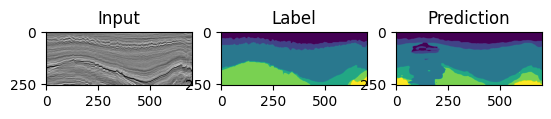

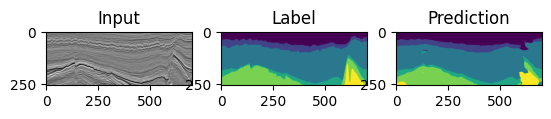

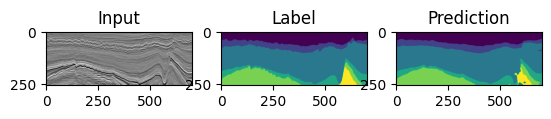

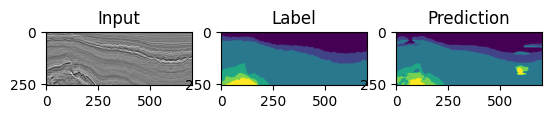

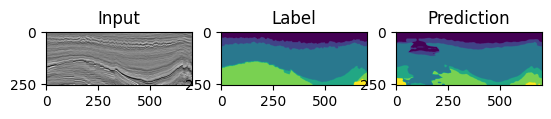

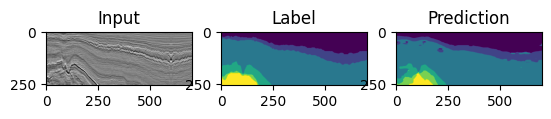

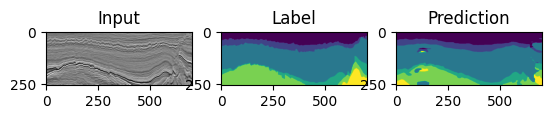

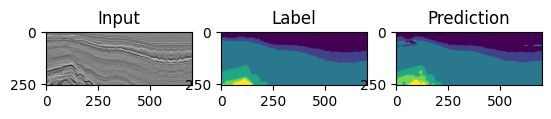

In [19]:
from matplotlib import pyplot as plt

# Fetch the first batch
first_batch = next(iter(test_dl))
X, y = first_batch

# Evaluate the first batch
downstream_model.eval()
X = X.to(device)
y = y.to(device)
logits = downstream_model(X.float())
predictions = torch.argmax(logits, dim=1, keepdim=True)

# Plot the predictions for the first batch
for i in range(len(X)):
    x_i = X[i]
    y_i = y[i]
    y_hat_i = predictions[i]
    plt.figure()
    plt.subplot(1, 3, 1)
    plt.imshow(x_i[0, :, :].to("cpu").numpy(), cmap="gray")
    plt.title("Input")
    plt.subplot(1, 3, 2)
    plt.imshow(y_i[:, :].to("cpu").numpy().transpose(1, 2, 0))
    plt.title("Label")
    plt.subplot(1, 3, 3)
    plt.imshow(y_hat_i[0, :, :].to("cpu").numpy())
    plt.title("Prediction")
    plt.show()